<a href="https://colab.research.google.com/github/KM-Rob/PBL_UWB/blob/main/UWB_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
# my drive mount with datafile
from google.colab import drive
drive.mount('/content/drive')
# '/content/drive/MyDrive/ColabFolder/PBL_UWB/table.csv'
'''

Mounted at /content/drive


In [6]:
!git clone https://github.com/KM-Rob/PBL_UWB.git

fatal: destination path 'PBL_UWB' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/content/PBL_UWB/simulation_results/table.csv',sep=';', decimal=',')
df['z_we']=0
df["Z_wy"]=0
df.head()

,d1,d2,d3,x_we,y_we,X_wy,Y_wy,z_we,Z_wy
0,4.336474,7.725822,6.693221,-3.2,-3.0,-3.185032,-2.917931,0,0
1,4.149860,7.741165,6.574950,-3.2,-2.8,-3.205937,-2.672134,0,0
2,4.075240,7.684606,6.403378,-3.2,-2.6,-3.245004,-2.486217,0,0
3,3.921239,7.553250,6.212391,-3.2,-2.4,-3.172344,-2.319115,0,0
4,3.767211,7.480597,6.085136,-3.2,-2.2,-3.115693,-2.156003,0,0


In [ ]:
len(df)

1088

# Wczytanie bibliotek

In [ ]:
# budowa modelu klasyfikacji
# funkcja do podziału zbioru danych na treningowy i walidacyjny
from sklearn.model_selection import train_test_split as tts
# obiekty do normalizacji i standaryzacji danych - będą używane zamiennie do porównania wyników
from sklearn.preprocessing import StandardScaler, Normalizer
# funkcja obliczania błędu średniokwadratowego do niezależnego obliczania błędu mse
from sklearn.metrics import mean_squared_error
# obiekt Sequential do budowania sieci neuronowej
from tensorflow.keras.models import Sequential
# obiekty do budowy sieci neuronowej - struktura gęsto połączona (Dense), funkcje aktywacji neuronu oraz algorytm optymalizacyjny (Adam)
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
# callbacki umożliwiające np wczesniejsze zatrzymanie uczenia żeby uniknąć przeuczenie i zapis najlepszego modelu do pliku
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# dodatkowe funkcje do odczytu modelu i wyświetlenia struktury sieci
from tensorflow.keras.saving import load_model
from tensorflow.keras.utils import plot_model

# model regresyjnego drzewa decyzyjnego - jako przykład alternatywnej metody optymalizacyjnej
from sklearn.tree import DecisionTreeRegressor

# wyświetlenie zbioru wejściowego i zbioru wyjściowego dla współżędnych X i Y

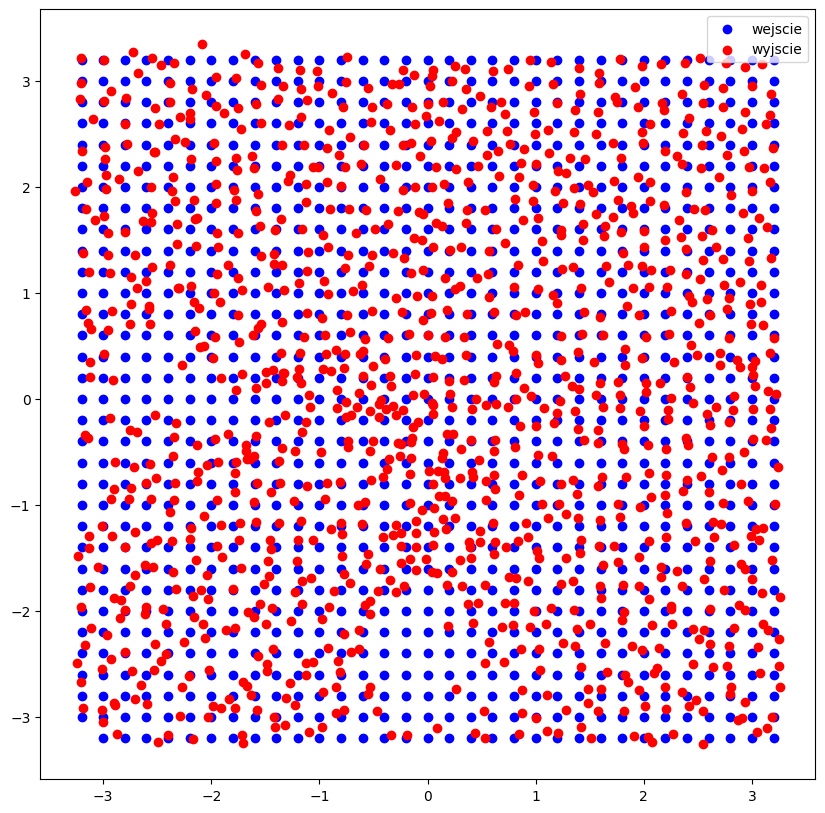

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(df['x_we'],df['y_we'],c='b',label='wejscie')
plt.scatter(df['X_wy'],df['Y_wy'],c='r',label='wyjscie')
plt.legend()
plt.show()

# Podział zbioru danych na zbiory treningowy, testowy i walidacyjny
Generalnie największy musi być uczący ok 70-80% - on będzie służył do uczenia czyli modyfikacji wag sieci (ogólnie modelu)
walidacyjny będzie używany w trakcie uczenia do sprawdzania czy nie uzyskano efektu przeuczenia
testowy będzie używany do sprawdzenia jakości modelu po nauczeniu

In [ ]:
# podział na zbiór uczący i testowy+walidacyjny z podziałem 60% na 40%
(x_train,x_test,y_train,y_test)=tts(df[['d1','d2','d3']],df[['x_we','y_we']],test_size=0.3)

In [ ]:
# podział zbioru testowy+walidacyjny na zbiór testowy i walidacyjny po 50%
(x_test,x_val,y_test,y_val)=tts(x_test,y_test,test_size=0.5)

In [ ]:
print("zbior uczacy: {}".format(len(x_train)))
print("zbior walidacyjny: {}".format(len(x_val)))
print("zbior testowy: {}".format(len(x_test)))

zbior uczacy: 761
zbior walidacyjny: 164
zbior testowy: 163


# standaryzacja lub normalizacja danych - **należy zrobić jedną**
W obydwu przypadkach robi się osobno dla danych wejściowych ucząc model na danych uczących i tym samym modelem przetwarza pozostałe dwa zbiory.

Na koniec jest wyświetlenie danych X,Y w postaci dwuwymiarowej i danych d1, d2, d3 w postaci trójwymiarowej

zadanie - dodać skalowanie MinMaxScaler dla zakresu 0-1 i sorawdzić działanie na warstwie wyjściowej z funkcją aktywacji relu ⏰

# Standaryzacja danych
przetworzenie danych wejściowych tak, aby średnia wynosiła 0 a odchylenie standardowe 1

In [ ]:
norm = 1
scaler_X = StandardScaler()
x_train = scaler_X.fit_transform(x_train)
x_test = scaler_X.transform(x_test)
x_val = scaler_X.transform(x_val)

In [ ]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)
y_val = scaler_y.transform(y_val)

# Normalizacja danych
przetworzenie danych wejściowych tak, aby zakres min max był w zakresie od -1 do 1

In [ ]:
norm = 2
normX = Normalizer()
x_train = normX.fit_transform(x_train)
x_test = normX.transform(x_test)
x_val = normX.transform(x_val)

In [ ]:
normY = Normalizer()
y_train = normY.fit_transform(y_train)
y_test = normY.transform(y_test)
y_val = normY.transform(y_val)

# Wyświetlenie przetworzonych danych

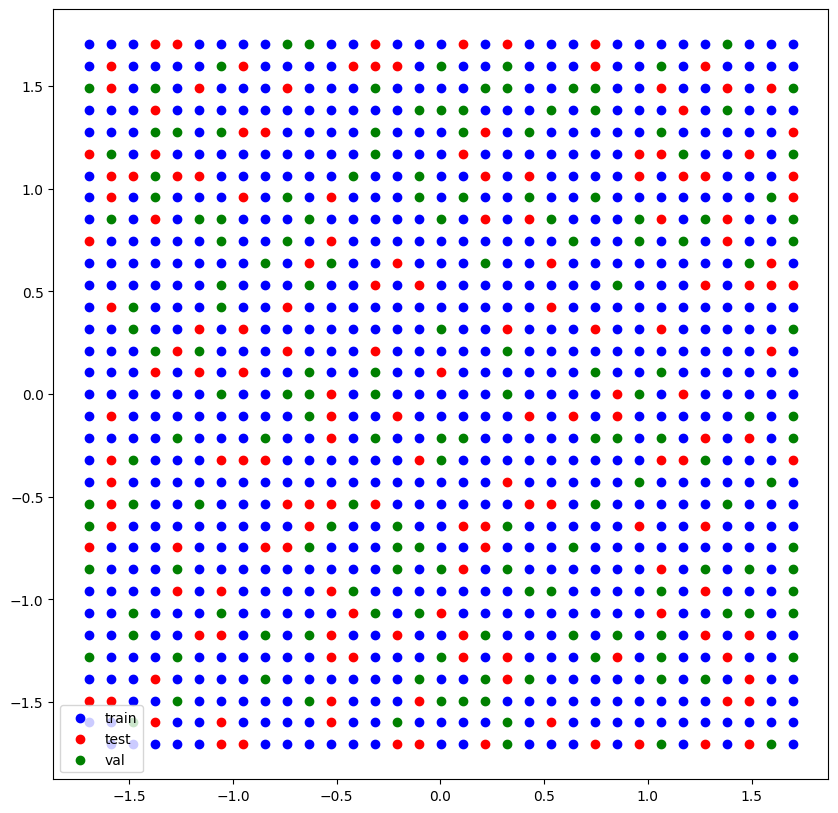

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_train[:,0],y_train[:,1],c='b',label='train')
plt.scatter(y_test[:,0],y_test[:,1],c='r',label='test')
plt.scatter(y_val[:,0],y_val[:,1],c='g',label='val')
plt.legend()
plt.show()

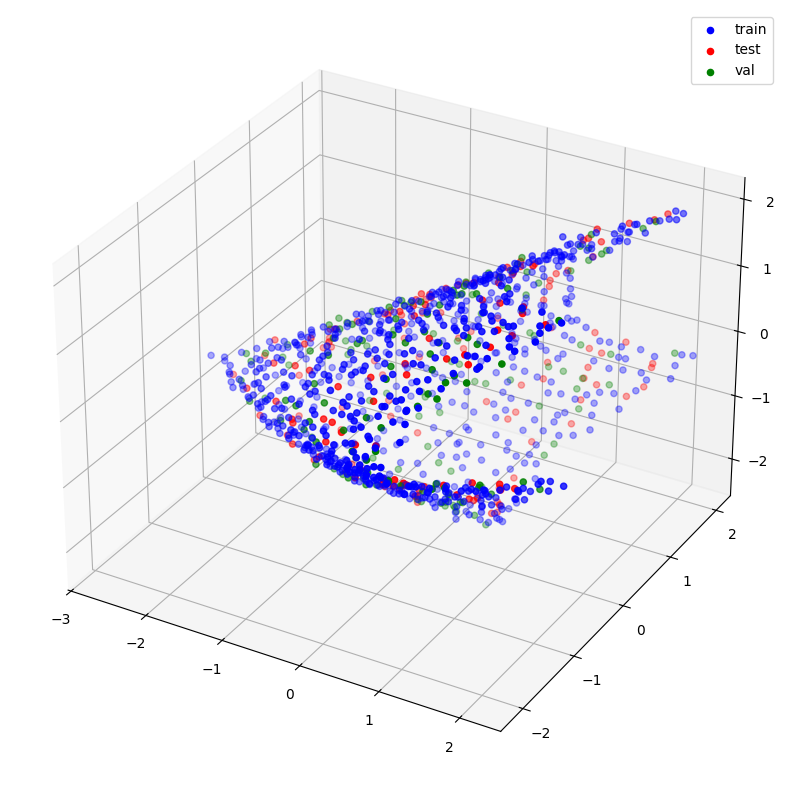

In [ ]:
fig =plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train[:,0],x_train[:,1],x_train[:,2],c='b',label='train')
ax.scatter(x_test[:,0],x_test[:,1],x_test[:,2],c='r',label='test')
ax.scatter(x_val[:,0],x_val[:,1],x_val[:,2],c='g',label='val')
plt.legend()
plt.show()

# Model drzewa decyzyjnego

In [ ]:
tree=DecisionTreeRegressor(max_depth=25, min_samples_leaf=1)
tree.fit(x_train,y_train)
tree.get_depth()

12

In [ ]:
y_pred=tree.predict(x_test)

In [ ]:
y_test['x_res']=y_pred[:,0]
y_test['y_res']=y_pred[:,1]
y_test.head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test['x_we'],y_test['y_we'],c='b',label='wejscie')
plt.scatter(y_test['x_res'],y_test['y_res'],c='r',label='wyjscie')
plt.legend()
plt.show()

In [ ]:
y_test.head()

In [ ]:
# Oblicz błąd średniokwadratowy dla każdej współrzędnej
mse_x = np.mean((y_test['x_we'] - y_test['x_res'])**2)
mse_y = np.mean((y_test['y_we'] - y_test['y_res'])**2)
# Zwróć średnią z błędów dla obu współrzędnych
(mse_x + mse_y) / 2

In [ ]:
'''
Wyniki dla różnych parametrów max_depth
--> zawsze wychodzi rzeczywisty max_depth = 12
depth = 5 mse = 0.18123073526134467
depth = 15 mse = 0.048348623853211016
depth = 25 mse = 0.047064220183486244
depth = 35 mse = 0.04651376146788991
depth = 45 mse = 0.04522935779816514
depth = 100 mse = 0.044587155963302746
'''

# funkcja Euklidesowej metryki jako metryka w uczeniu modelu

$$
d = \sqrt{(x_{\text{pred}} - x)^2 + (y_{\text{pred}} - y)^2}
$$

(opcja do sprawdzenia ✅ )

In [ ]:
import tensorflow as tf

def euclidean_distance(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1))

# Sieć neuronowa
Zbudowana na obiekcie sekwencyjnym, struktura podana w drugiej komórce

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(6,input_dim=3,activation=activations.relu))
model.add(Dense(24,activation=activations.relu))
#model.add(Dense(12,activation=activations.relu))
model.add(Dense(2,activation=activations.leaky_relu))
# model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mse'])
model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=[euclidean_distance])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 24)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242 (968.00 B)

 Trainable params: 242 (968.00 B)

 Non-trainable params: 0 (0.00 B)

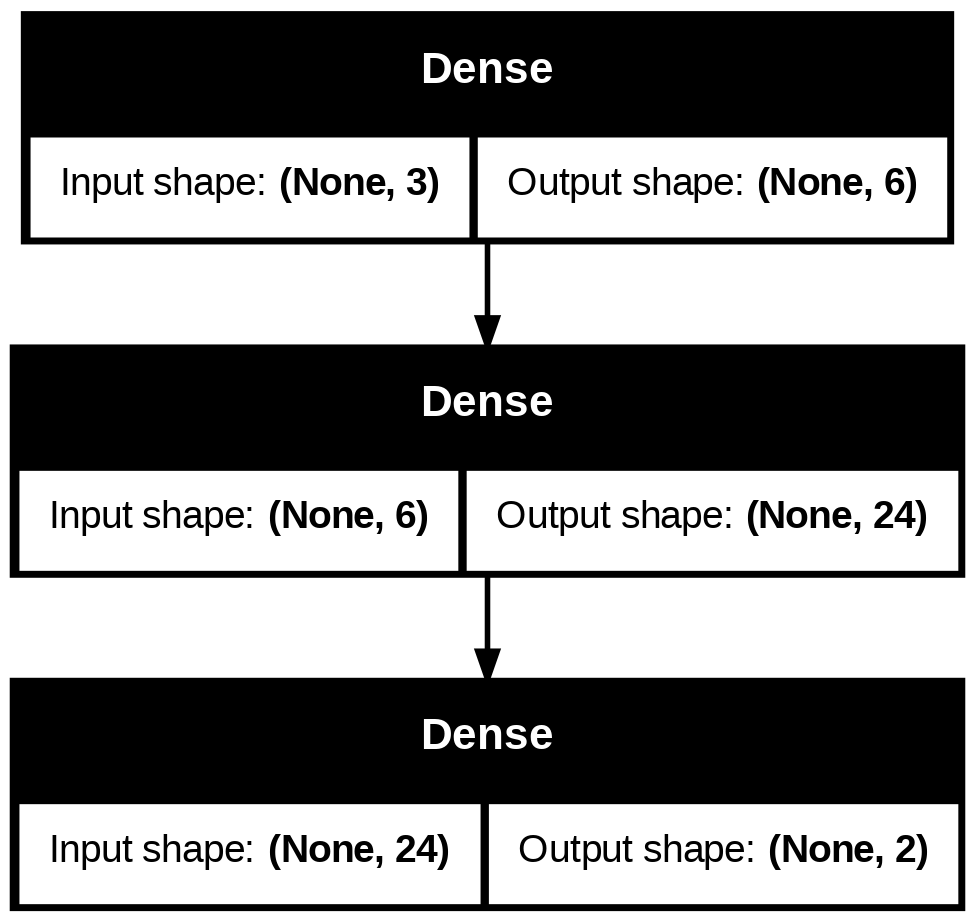

In [ ]:
plot_model(model,show_shapes=True)

Callbacki:
EarlyStopping - zatrzymuje uczenie, jeśli model nie poprawi swoich paramterów przez *patience* epok

ModelCheckpoint - zapisuje najlepszy model - ostatni nie musi byc najlepszym, każdy kolejny najlepszy zostaje nadpisany

In [ ]:
es = EarlyStopping(patience=30, verbose=True)
chp = ModelCheckpoint("best_model.h5", save_best_only=True, verbose=True)

Trening modelu.
Uczymy na danych treningowych a do sprawdzenia jakości modleu używamy danych walidacyjnych, dodatkowo aktywacja obydwu callbacków

In [ ]:
hist = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val),callbacks=[es,chp])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 1.3830 - loss: 1.0843
Epoch 1: val_loss improved from inf to 1.01562, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - euclidean_distance: 1.3820 - loss: 1.0828 - val_euclidean_distance: 1.3489 - val_loss: 1.0156
Epoch 2/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 1.2941 - loss: 0.9591 
Epoch 2: val_loss improved from 1.01562 to 0.92203, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 1.2915 - loss: 0.9554 - val_euclidean_distance: 1.2772 - val_loss: 0.9220
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 1.2155 - loss: 0.8556 
Epoch 3: val_loss improved from 0.92203 to 0.83284, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 1.2152 - loss: 0.8555 - val_euclidean_distance: 1.1955 - val_loss: 0.8328
Epoch 4/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 1.1817 - loss: 0.8276 
Epoch 4: val_loss improved from 0.83284 to 0.73479, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 1.1725 - loss: 0.8174 - val_euclidean_distance: 1.0957 - val_loss: 0.7348
Epoch 5/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 1.0686 - loss: 0.7046 
Epoch 5: val_loss improved from 0.73479 to 0.60999, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 1.0621 - loss: 0.6970 - val_euclidean_distance: 0.9933 - val_loss: 0.6100
Epoch 6/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.9556 - loss: 0.5697 
Epoch 6: val_loss improved from 0.60999 to 0.50891, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.9529 - loss: 0.5676 - val_euclidean_distance: 0.8985 - val_loss: 0.5089
Epoch 7/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.8583 - loss: 0.4806  
Epoch 7: val_loss improved from 0.50891 to 0.44299, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.8583 - loss: 0.4809 - val_euclidean_distance: 0.8194 - val_loss: 0.4430
Epoch 8/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.7782 - loss: 0.4181  
Epoch 8: val_loss improved from 0.44299 to 0.39938, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.7815 - loss: 0.4205 - val_euclidean_distance: 0.7693 - val_loss: 0.3994
Epoch 9/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.7935 - loss: 0.4289  
Epoch 9: val_loss improved from 0.39938 to 0.36304, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.7887 - loss: 0.4245 - val_euclidean_distance: 0.7316 - val_loss: 0.3630
Epoch 10/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.7178 - loss: 0.3557 
Epoch 10: val_loss improved from 0.36304 to 0.33265, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.7178 - loss: 0.3561 - val_euclidean_distance: 0.7005 - val_loss: 0.3327
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.7047 - loss: 0.3448  
Epoch 11: val_loss improved from 0.33265 to 0.30228, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.7041 - loss: 0.3441 - val_euclidean_distance: 0.6718 - val_loss: 0.3023
Epoch 12/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.6528 - loss: 0.2959  
Epoch 12: val_loss improved from 0.30228 to 0.27290, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.6532 - loss: 0.2961 - val_euclidean_distance: 0.6395 - val_loss: 0.2729
Epoch 13/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.6494 - loss: 0.2869  
Epoch 13: val_loss improved from 0.27290 to 0.24206, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.6425 - loss: 0.2816 - val_euclidean_distance: 0.6048 - val_loss: 0.2421
Epoch 14/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.6116 - loss: 0.2520  
Epoch 14: val_loss improved from 0.24206 to 0.21245, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.6048 - loss: 0.2473 - val_euclidean_distance: 0.5692 - val_loss: 0.2125
Epoch 15/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.5601 - loss: 0.2114 
Epoch 15: val_loss improved from 0.21245 to 0.18550, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.5588 - loss: 0.2103 - val_euclidean_distance: 0.5339 - val_loss: 0.1855
Epoch 16/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.5232 - loss: 0.1846 
Epoch 16: val_loss improved from 0.18550 to 0.16008, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.5228 - loss: 0.1841 - val_euclidean_distance: 0.4981 - val_loss: 0.1601
Epoch 17/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.4994 - loss: 0.1612  
Epoch 17: val_loss improved from 0.16008 to 0.13825, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.4939 - loss: 0.1587 - val_euclidean_distance: 0.4639 - val_loss: 0.1382
Epoch 18/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.4500 - loss: 0.1314 
Epoch 18: val_loss improved from 0.13825 to 0.11880, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.4500 - loss: 0.1314 - val_euclidean_distance: 0.4289 - val_loss: 0.1188
Epoch 19/100
11/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.4234 - loss: 0.1189 
Epoch 19: val_loss improved from 0.11880 to 0.10122, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.4186 - loss: 0.1155 - val_euclidean_distance: 0.3985 - val_loss: 0.1012
Epoch 20/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.3953 - loss: 0.0983 
Epoch 20: val_loss improved from 0.10122 to 0.08654, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.3930 - loss: 0.0976 - val_euclidean_distance: 0.3681 - val_loss: 0.0865
Epoch 21/100
12/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.3833 - loss: 0.0935 
Epoch 21: val_loss improved from 0.08654 to 0.07326, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.3723 - loss: 0.0886 - val_euclidean_distance: 0.3386 - val_loss: 0.0733
Epoch 22/100
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.3307 - loss: 0.0703 
Epoch 22: val_loss improved from 0.07326 to 0.06243, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.3306 - loss: 0.0699 - val_euclidean_distance: 0.3139 - val_loss: 0.0624
Epoch 23/100
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.3193 - loss: 0.0650 
Epoch 23: val_loss improved from 0.06243 to 0.05255, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.3132 - loss: 0.0625 - val_euclidean_distance: 0.2881 - val_loss: 0.0525
Epoch 24/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.2826 - loss: 0.0519 
Epoch 24: val_loss improved from 0.05255 to 0.04542, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - euclidean_distance: 0.2815 - loss: 0.0511 - val_euclidean_distance: 0.2665 - val_loss: 0.0454
Epoch 25/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.2666 - loss: 0.0462  
Epoch 25: val_loss improved from 0.04542 to 0.03963, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - euclidean_distance: 0.2631 - loss: 0.0448 - val_euclidean_distance: 0.2486 - val_loss: 0.0396
Epoch 26/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.2424 - loss: 0.0374
Epoch 26: val_loss improved from 0.03963 to 0.03567, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - euclidean_distance: 0.2423 - loss: 0.0374 - val_euclidean_distance: 0.2345 - val_loss: 0.0357
Epoch 27/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.2224 - loss: 0.0318  
Epoch 27: val_loss improved from 0.03567 to 0.03156, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - euclidean_distance: 0.2225 - loss: 0.0319 - val_euclidean_distance: 0.2194 - val_loss: 0.0316
Epoch 28/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.2155 - loss: 0.0302  
Epoch 28: val_loss improved from 0.03156 to 0.02925, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.2140 - loss: 0.0299 - val_euclidean_distance: 0.2104 - val_loss: 0.0293
Epoch 29/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1995 - loss: 0.0263 
Epoch 29: val_loss improved from 0.02925 to 0.02664, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1996 - loss: 0.0263 - val_euclidean_distance: 0.2001 - val_loss: 0.0266
Epoch 30/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - euclidean_distance: 0.1830 - loss: 0.0221
Epoch 30: val_loss improved from 0.02664 to 0.02495, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1858 - loss: 0.0232 - val_euclidean_distance: 0.1944 - val_loss: 0.0250
Epoch 31/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1834 - loss: 0.0231 
Epoch 31: val_loss improved from 0.02495 to 0.02308, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1831 - loss: 0.0230 - val_euclidean_distance: 0.1854 - val_loss: 0.0231
Epoch 32/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1815 - loss: 0.0229  
Epoch 32: val_loss improved from 0.02308 to 0.02187, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.1805 - loss: 0.0225 - val_euclidean_distance: 0.1809 - val_loss: 0.0219
Epoch 33/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1698 - loss: 0.0195 
Epoch 33: val_loss improved from 0.02187 to 0.02083, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.1697 - loss: 0.0195 - val_euclidean_distance: 0.1764 - val_loss: 0.0208
Epoch 34/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1652 - loss: 0.0182  
Epoch 34: val_loss improved from 0.02083 to 0.01989, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1651 - loss: 0.0182 - val_euclidean_distance: 0.1710 - val_loss: 0.0199
Epoch 35/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1602 - loss: 0.0177  
Epoch 35: val_loss improved from 0.01989 to 0.01900, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1600 - loss: 0.0177 - val_euclidean_distance: 0.1666 - val_loss: 0.0190
Epoch 36/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1485 - loss: 0.0155  
Epoch 36: val_loss improved from 0.01900 to 0.01827, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1498 - loss: 0.0157 - val_euclidean_distance: 0.1632 - val_loss: 0.0183
Epoch 37/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1505 - loss: 0.0152  
Epoch 37: val_loss improved from 0.01827 to 0.01804, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1505 - loss: 0.0152 - val_euclidean_distance: 0.1612 - val_loss: 0.0180
Epoch 38/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1428 - loss: 0.0142 
Epoch 38: val_loss improved from 0.01804 to 0.01692, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1430 - loss: 0.0142 - val_euclidean_distance: 0.1553 - val_loss: 0.0169
Epoch 39/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - euclidean_distance: 0.1695 - loss: 0.0183
Epoch 39: val_loss improved from 0.01692 to 0.01630, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1429 - loss: 0.0141 - val_euclidean_distance: 0.1512 - val_loss: 0.0163
Epoch 40/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1370 - loss: 0.0130  
Epoch 40: val_loss improved from 0.01630 to 0.01571, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1372 - loss: 0.0131 - val_euclidean_distance: 0.1488 - val_loss: 0.0157
Epoch 41/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - euclidean_distance: 0.1239 - loss: 0.0143
Epoch 41: val_loss improved from 0.01571 to 0.01538, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.1334 - loss: 0.0131 - val_euclidean_distance: 0.1469 - val_loss: 0.0154
Epoch 42/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - euclidean_distance: 0.1494 - loss: 0.0155
Epoch 42: val_loss improved from 0.01538 to 0.01443, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - euclidean_distance: 0.1342 - loss: 0.0125 - val_euclidean_distance: 0.1425 - val_loss: 0.0144
Epoch 43/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - euclidean_distance: 0.1155 - loss: 0.0096
Epoch 43: val_loss improved from 0.01443 to 0.01388, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1269 - loss: 0.0113 - val_euclidean_distance: 0.1387 - val_loss: 0.0139
Epoch 44/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - euclidean_distance: 0.1248 - loss: 0.0109
Epoch 44: val_loss improved from 0.01388 to 0.01348, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - euclidean_distance: 0.1258 - loss: 0.0110 - val_euclidean_distance: 0.1367 - val_loss: 0.0135
Epoch 45/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1282 - loss: 0.0118  
Epoch 45: val_loss improved from 0.01348 to 0.01336, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.1277 - loss: 0.0117 - val_euclidean_distance: 0.1339 - val_loss: 0.0134
Epoch 46/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1213 - loss: 0.0108 
Epoch 46: val_loss improved from 0.01336 to 0.01277, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1212 - loss: 0.0108 - val_euclidean_distance: 0.1322 - val_loss: 0.0128
Epoch 47/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1190 - loss: 0.0100 
Epoch 47: val_loss improved from 0.01277 to 0.01253, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.1190 - loss: 0.0101 - val_euclidean_distance: 0.1315 - val_loss: 0.0125
Epoch 48/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1168 - loss: 0.0098 
Epoch 48: val_loss improved from 0.01253 to 0.01230, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1171 - loss: 0.0099 - val_euclidean_distance: 0.1294 - val_loss: 0.0123
Epoch 49/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1156 - loss: 0.0093  
Epoch 49: val_loss improved from 0.01230 to 0.01181, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.1148 - loss: 0.0093 - val_euclidean_distance: 0.1270 - val_loss: 0.0118
Epoch 50/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1158 - loss: 0.0099  
Epoch 50: val_loss improved from 0.01181 to 0.01157, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1154 - loss: 0.0098 - val_euclidean_distance: 0.1248 - val_loss: 0.0116
Epoch 51/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1116 - loss: 0.0088  
Epoch 51: val_loss improved from 0.01157 to 0.01123, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1118 - loss: 0.0089 - val_euclidean_distance: 0.1232 - val_loss: 0.0112
Epoch 52/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - euclidean_distance: 0.1380 - loss: 0.0124
Epoch 52: val_loss improved from 0.01123 to 0.01084, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1160 - loss: 0.0096 - val_euclidean_distance: 0.1212 - val_loss: 0.0108
Epoch 53/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1108 - loss: 0.0091  
Epoch 53: val_loss improved from 0.01084 to 0.01053, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1105 - loss: 0.0091 - val_euclidean_distance: 0.1190 - val_loss: 0.0105
Epoch 54/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1048 - loss: 0.0080  
Epoch 54: val_loss improved from 0.01053 to 0.01031, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.1049 - loss: 0.0080 - val_euclidean_distance: 0.1181 - val_loss: 0.0103
Epoch 55/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1066 - loss: 0.0085  
Epoch 55: val_loss improved from 0.01031 to 0.00998, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1062 - loss: 0.0084 - val_euclidean_distance: 0.1158 - val_loss: 0.0100
Epoch 56/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.1058 - loss: 0.0086  
Epoch 56: val_loss improved from 0.00998 to 0.00980, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1052 - loss: 0.0084 - val_euclidean_distance: 0.1151 - val_loss: 0.0098
Epoch 57/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1031 - loss: 0.0077  
Epoch 57: val_loss improved from 0.00980 to 0.00959, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1031 - loss: 0.0077 - val_euclidean_distance: 0.1129 - val_loss: 0.0096
Epoch 58/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1012 - loss: 0.0075  
Epoch 58: val_loss improved from 0.00959 to 0.00925, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1011 - loss: 0.0075 - val_euclidean_distance: 0.1114 - val_loss: 0.0093
Epoch 59/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.0949 - loss: 0.0065  
Epoch 59: val_loss improved from 0.00925 to 0.00923, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - euclidean_distance: 0.0951 - loss: 0.0065 - val_euclidean_distance: 0.1124 - val_loss: 0.0092
Epoch 60/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.1016 - loss: 0.0074  
Epoch 60: val_loss improved from 0.00923 to 0.00888, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.1014 - loss: 0.0074 - val_euclidean_distance: 0.1093 - val_loss: 0.0089
Epoch 61/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.0984 - loss: 0.0070  
Epoch 61: val_loss improved from 0.00888 to 0.00866, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0982 - loss: 0.0070 - val_euclidean_distance: 0.1086 - val_loss: 0.0087
Epoch 62/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.0965 - loss: 0.0066 
Epoch 62: val_loss improved from 0.00866 to 0.00858, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.0965 - loss: 0.0066 - val_euclidean_distance: 0.1074 - val_loss: 0.0086
Epoch 63/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.0965 - loss: 0.0067 
Epoch 63: val_loss improved from 0.00858 to 0.00827, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.0954 - loss: 0.0066 - val_euclidean_distance: 0.1058 - val_loss: 0.0083
Epoch 64/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.0903 - loss: 0.0056 
Epoch 64: val_loss improved from 0.00827 to 0.00804, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.0911 - loss: 0.0058 - val_euclidean_distance: 0.1044 - val_loss: 0.0080
Epoch 65/100
12/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0874 - loss: 0.0055 
Epoch 65: val_loss improved from 0.00804 to 0.00788, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - euclidean_distance: 0.0895 - loss: 0.0058 - val_euclidean_distance: 0.1037 - val_loss: 0.0079
Epoch 66/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.0883 - loss: 0.0056  
Epoch 66: val_loss improved from 0.00788 to 0.00773, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - euclidean_distance: 0.0890 - loss: 0.0057 - val_euclidean_distance: 0.1031 - val_loss: 0.0077
Epoch 67/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.0891 - loss: 0.0059 
Epoch 67: val_loss improved from 0.00773 to 0.00749, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.0896 - loss: 0.0058 - val_euclidean_distance: 0.1006 - val_loss: 0.0075
Epoch 68/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0896 - loss: 0.0058
Epoch 68: val_loss improved from 0.00749 to 0.00744, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - euclidean_distance: 0.0894 - loss: 0.0057 - val_euclidean_distance: 0.1008 - val_loss: 0.0074
Epoch 69/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.0842 - loss: 0.0052  
Epoch 69: val_loss improved from 0.00744 to 0.00726, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - euclidean_distance: 0.0850 - loss: 0.0052 - val_euclidean_distance: 0.1001 - val_loss: 0.0073
Epoch 70/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.0841 - loss: 0.0047  
Epoch 70: val_loss improved from 0.00726 to 0.00721, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.0845 - loss: 0.0048 - val_euclidean_distance: 0.0988 - val_loss: 0.0072
Epoch 71/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - euclidean_distance: 0.0935 - loss: 0.0053
Epoch 71: val_loss improved from 0.00721 to 0.00705, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0893 - loss: 0.0056 - val_euclidean_distance: 0.0983 - val_loss: 0.0070
Epoch 72/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - euclidean_distance: 0.0786 - loss: 0.0041
Epoch 72: val_loss improved from 0.00705 to 0.00685, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.0862 - loss: 0.0051 - val_euclidean_distance: 0.0972 - val_loss: 0.0069
Epoch 73/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.0849 - loss: 0.0053 
Epoch 73: val_loss improved from 0.00685 to 0.00667, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0849 - loss: 0.0053 - val_euclidean_distance: 0.0957 - val_loss: 0.0067
Epoch 74/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.0808 - loss: 0.0047  
Epoch 74: val_loss did not improve from 0.00667
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0818 - loss: 0.0048 - val_euclidean_distance: 0.0981 - val_loss: 0.0068
Epoch 75/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.0857 - loss: 0.0052  
Epoch 75: val_loss improved from 0.00667 to 0.00637, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0856 - loss: 0.0052 - val_euclidean_distance: 0.0936 - val_loss: 0.0064
Epoch 76/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - euclidean_distance: 0.0847 - loss: 0.0054
Epoch 76: val_loss did not improve from 0.00637
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0832 - loss: 0.0048 - val_euclidean_distance: 0.0937 - val_loss: 0.0064
Epoch 77/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.0849 - loss: 0.0049  
Epoch 77: val_loss improved from 0.00637 to 0.00618, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - euclidean_distance: 0.0846 - loss: 0.0049 - val_euclidean_distance: 0.0929 - val_loss: 0.0062
Epoch 78/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0807 - loss: 0.0044 
Epoch 78: val_loss improved from 0.00618 to 0.00597, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - euclidean_distance: 0.0812 - loss: 0.0045 - val_euclidean_distance: 0.0912 - val_loss: 0.0060
Epoch 79/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.0832 - loss: 0.0049
Epoch 79: val_loss improved from 0.00597 to 0.00589, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - euclidean_distance: 0.0831 - loss: 0.0049 - val_euclidean_distance: 0.0908 - val_loss: 0.0059
Epoch 80/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.0820 - loss: 0.0047
Epoch 80: val_loss did not improve from 0.00589
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - euclidean_distance: 0.0820 - loss: 0.0047 - val_euclidean_distance: 0.0908 - val_loss: 0.0059
Epoch 81/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0787 - loss: 0.0041
Epoch 81: val_loss did not improve from 0.00589
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - euclidean_distance: 0.0788 - loss: 0.0042 - val_euclidean_distance: 0.0918 - val_loss: 0.0059
Epoch 82/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0822 - loss: 0.0048
Epoch 82: val_loss improved from 0.00589 to 0.00553, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - euclidean_distance: 0.0819 - loss: 0.0047 - val_euclidean_distance: 0.0887 - val_loss: 0.0055
Epoch 83/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - euclidean_distance: 0.0768 - loss: 0.0040
Epoch 83: val_loss improved from 0.00553 to 0.00539, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - euclidean_distance: 0.0771 - loss: 0.0041 - val_euclidean_distance: 0.0873 - val_loss: 0.0054
Epoch 84/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0782 - loss: 0.0042
Epoch 84: val_loss improved from 0.00539 to 0.00529, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - euclidean_distance: 0.0782 - loss: 0.0042 - val_euclidean_distance: 0.0868 - val_loss: 0.0053
Epoch 85/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - euclidean_distance: 0.0753 - loss: 0.0038
Epoch 85: val_loss improved from 0.00529 to 0.00521, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - euclidean_distance: 0.0760 - loss: 0.0039 - val_euclidean_distance: 0.0866 - val_loss: 0.0052
Epoch 86/100
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - euclidean_distance: 0.0773 - loss: 0.0039 
Epoch 86: val_loss improved from 0.00521 to 0.00502, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.0770 - loss: 0.0039 - val_euclidean_distance: 0.0844 - val_loss: 0.0050
Epoch 87/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - euclidean_distance: 0.0768 - loss: 0.0044 
Epoch 87: val_loss did not improve from 0.00502
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0767 - loss: 0.0043 - val_euclidean_distance: 0.0852 - val_loss: 0.0051
Epoch 88/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - euclidean_distance: 0.0616 - loss: 0.0027
Epoch 88: val_loss improved from 0.00502 to 0.00489, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0728 - loss: 0.0037 - val_euclidean_distance: 0.0840 - val_loss: 0.0049
Epoch 89/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - euclidean_distance: 0.0788 - loss: 0.0041
Epoch 89: val_loss improved from 0.00489 to 0.00479, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.0752 - loss: 0.0039 - val_euclidean_distance: 0.0830 - val_loss: 0.0048
Epoch 90/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0721 - loss: 0.0036
Epoch 90: val_loss improved from 0.00479 to 0.00468, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - euclidean_distance: 0.0725 - loss: 0.0036 - val_euclidean_distance: 0.0819 - val_loss: 0.0047
Epoch 91/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.0740 - loss: 0.0037
Epoch 91: val_loss improved from 0.00468 to 0.00459, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - euclidean_distance: 0.0739 - loss: 0.0037 - val_euclidean_distance: 0.0817 - val_loss: 0.0046
Epoch 92/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.0720 - loss: 0.0035
Epoch 92: val_loss improved from 0.00459 to 0.00453, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - euclidean_distance: 0.0721 - loss: 0.0035 - val_euclidean_distance: 0.0815 - val_loss: 0.0045
Epoch 93/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - euclidean_distance: 0.0750 - loss: 0.0037
Epoch 93: val_loss improved from 0.00453 to 0.00452, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - euclidean_distance: 0.0748 - loss: 0.0037 - val_euclidean_distance: 0.0813 - val_loss: 0.0045
Epoch 94/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - euclidean_distance: 0.0716 - loss: 0.0035
Epoch 94: val_loss improved from 0.00452 to 0.00434, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - euclidean_distance: 0.0717 - loss: 0.0035 - val_euclidean_distance: 0.0800 - val_loss: 0.0043
Epoch 95/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - euclidean_distance: 0.0727 - loss: 0.0036
Epoch 95: val_loss improved from 0.00434 to 0.00408, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - euclidean_distance: 0.0726 - loss: 0.0036 - val_euclidean_distance: 0.0776 - val_loss: 0.0041
Epoch 96/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0709 - loss: 0.0033
Epoch 96: val_loss improved from 0.00408 to 0.00398, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - euclidean_distance: 0.0709 - loss: 0.0033 - val_euclidean_distance: 0.0768 - val_loss: 0.0040
Epoch 97/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - euclidean_distance: 0.0727 - loss: 0.0036
Epoch 97: val_loss did not improve from 0.00398
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - euclidean_distance: 0.0726 - loss: 0.0035 - val_euclidean_distance: 0.0779 - val_loss: 0.0041
Epoch 98/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - euclidean_distance: 0.0709 - loss: 0.0034
Epoch 98: val_loss improved from 0.00398 to 0.00385, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - euclidean_distance: 0.0708 - loss: 0.0034 - val_euclidean_distance: 0.0755 - val_loss: 0.0038
Epoch 99/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - euclidean_distance: 0.0727 - loss: 0.0037 
Epoch 99: val_loss improved from 0.00385 to 0.00380, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0718 - loss: 0.0035 - val_euclidean_distance: 0.0754 - val_loss: 0.0038
Epoch 100/100
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - euclidean_distance: 0.0766 - loss: 0.0039
Epoch 100: val_loss improved from 0.00380 to 0.00376, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - euclidean_distance: 0.0698 - loss: 0.0032 - val_euclidean_distance: 0.0750 - val_loss: 0.0038


Wyświetlenie historii uczenia modelu.

Loss - funkcja straty

mae - funkcja błędu *Mean Absolute Error*

mse - funkcja błedu *Mean Square Error*

euclidean_distance - funkcja metryki *odległości euklidesowej*

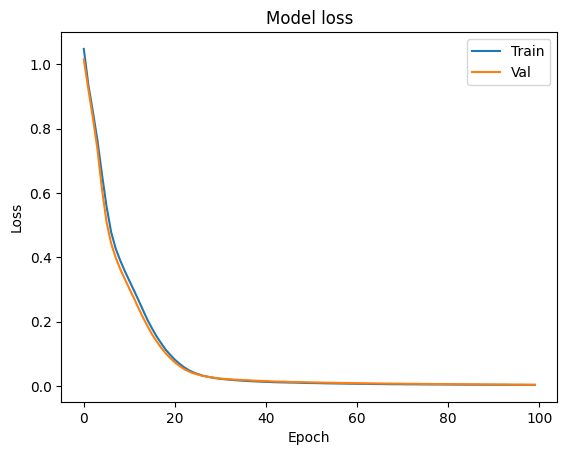

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

In [ ]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Accuracy mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

KeyError: 'mae'

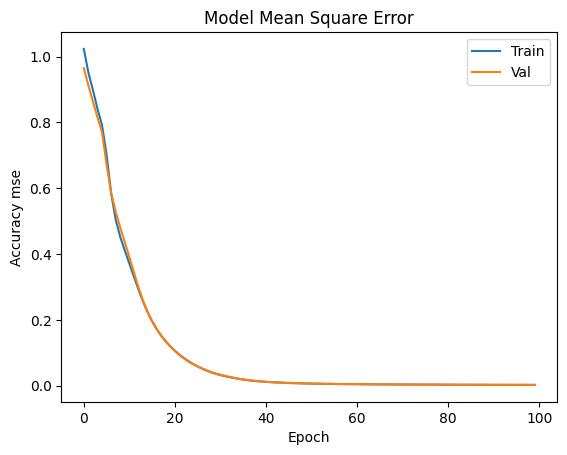

In [ ]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model Mean Square Error')
plt.ylabel('Accuracy mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

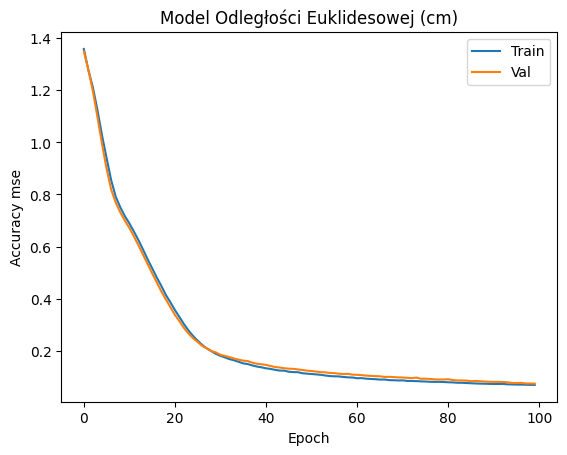

In [ ]:
plt.plot(hist.history['euclidean_distance'])
plt.plot(hist.history['val_euclidean_distance'])
plt.title('Model Odległości Euklidesowej (cm)')
plt.ylabel('Accuracy mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

testujemy nauczony model na danych testowych

In [ ]:
y_model = model.predict(x_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


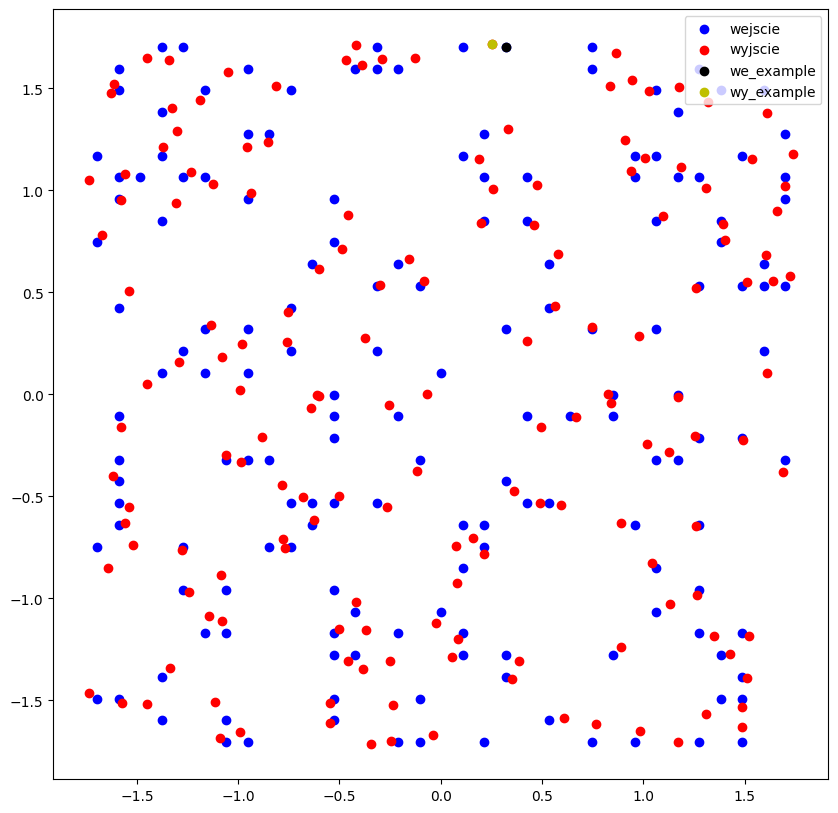

In [ ]:
example = 10
plt.figure(figsize=(10,10))
plt.scatter(y_test[:,0],y_test[:,1],c='b',label='wejscie')
plt.scatter(y_model[:,0],y_model[:,1],c='r',label='wyjscie')
plt.scatter(y_test[example,0],y_test[example,1],c='k',label='we_example')
plt.scatter(y_model[example,0],y_model[example,1],c='y',label='wy_example')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test,y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - euclidean_distance: 0.0742 - loss: 0.0037


[0.0035025610122829676, 0.07255402952432632]

błąd MSE dla danych testowych wzorcowe (y_test) i uzyskane z modelu (y_model)

wynik podawany jest w cm2

In [ ]:
mse = mean_squared_error(y_test, y_model)
mse

0.0035025608576684975

# przechodzimy spowrotem na dane przed standaryzacją/normalizacją
norm = 1 - standaryzacja danych

norm = 2 - normalizacja danych

In [ ]:
if norm == 1:
  ytest_ = scaler_y.inverse_transform(y_test)
  ymodel_ = scaler_y.inverse_transform(y_model)


funkcja obliczająca błąd euklidesowy w cm
$$
d = \sqrt{(x_{\text{pred}} - x)^2 + (y_{\text{pred}} - y)^2}
$$

In [ ]:
def mean_euclidean_error(y_true, y_pred):
    """
    Oblicza średni błąd euklidesowy między punktami 2D.

    Parametry:
    y_true -- rzeczywiste wartości (n, 2)
    y_pred -- przewidywane wartości (n, 2)

    Zwraca:
    Średni błąd euklidesowy (float)
    """
    diffs = y_true - y_pred
    distances = np.linalg.norm(diffs, axis=1)
    return np.mean(distances)

In [ ]:
mee = mean_euclidean_error(y_test, y_model)
print(f"Uzyskany błąd euklidesowy: {mee:.2f} cm")

Uzyskany błąd euklidesowy: 0.07 cm
